<a href="https://colab.research.google.com/github/AshOne91/PLAYDATA-COLAB/blob/main/2%EB%B2%88%EC%A7%B8_%EC%9E%90%EC%97%B0%EC%96%B4_%EC%B2%98%EB%A6%AC_%EC%A0%84%ED%86%B5%EC%A0%81_%EA%B8%B0%EB%B2%95(NLP_%EA%B7%9C%EC%B9%99%EA%B8%B0%EB%B0%98_%EC%8B%9C%EC%8A%A4%ED%85%9C%2C_NLP_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

셀프어텐션
```
사용이유?
1. 위치에 상관없이 모든 토큰간의 관계를 학습
2. 병렬 처리가 가능 효율적인 계산
3. 장거리 의존성 문제를 해결(RNN 극복)
4. 각 토큰이 다른 토큰관 얼마나 연관되어 있는지 가중치로 표현
```

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

어텐션
```
Query
Key
Value
멀티헤드 어텐션 : 어텐션을 여러 번 병렬로 수행하는 구조
1.각 헤드마다 Q K V를 독립적으로 선형 변환
2. 독립적으로 어텐션을 계산
3. 결과를 이어붙인 다음 선형변환
```

In [ ]:
class SelfAttention(nn.Module):
  # embed_size : 임베딩 차원
  # heads : 멀티 헤드 어텐션에서 사용할 헤드의 수
  def __init__(self, embed_size, heads):
    super().__init__()
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size // heads
    # embed_size 가 heads로 나누어 떨어지는지 확인
    assert (self.head_dim * heads == embed_size), "embed_size must be div by heads"
    # query key value에 대한 선형 변환
    self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.fc_out = nn.Linear(heads * self.head_dim, embed_size)
  def forward(self,values,keys,querys, mask= None):
    '''
      매개변수
        values : (batch_size, seq_len, embed_size)
        keys : (batch_size, seq_len, embed_size)
        querys : (batch_size, seq_len, embed_size)
        mask : 어텐션 마스크(선택적, 주로 패딩이나 미래 토큰을 가리는 데 사용)
      반환
        out: 어텐션 적용 결과 (batch_size, seq_len, embed_size)
        attention_weights: 어텐션 가중치 맵(시각화용)
    '''
    # 1 배치크기 가져오기
    N = querys.shape[0]
    value_len, key_len, query_len = values.shape[1], keys.shape[1], querys.shape[1]
    # 2. values,keys,queries를 여러 헤드로 분할
    values = values.reshape(N, value_len, self.heads, self.head_dim)
    keys = keys.reshape(N, key_len, self.heads, self.head_dim)
    querys = querys.reshape(N, query_len, self.heads, self.head_dim)
    # 3.선형 변환 적용
    values = self.values(values)
    keys = self.keys(keys)
    querys = self.queries(querys)
    # 4 어텐션 점수 계산  : query 와 key의 내적  query x key^t
    # 각 헤드별로 query와 key이 내적(dot product)을 계산
    # n 배치, q : 쿼리길이, h : 헤드수, d: 각 헤드의 임베딩 차원
    energy = torch.einsum("nqhd,nkhd->nhqk",[querys,keys])
    # 5. 스케일링 : 이베딩 차원의 제곱근으로 나눔 --> 정규화
    # softmax에 적용하기 전에  안정화를 위해서
    scaled_energy = energy / (self.embed_size ** (1/2))
    # 6. 마스크 적용
    if mask is not None:
      scaled_energy = scaled_energy.masked_fill(mask == 0, float("-1e20"))
    # 7. 소프트 맥스로 어텐션의 가중치 계산
    attention_weights =  F.softmax(scaled_energy, dim=3)
    # 8 가중치와 값 벡터 곱하기
    out = torch.einsum("nhql,nlhd->nqhd",[attention_weights,values])
    # 9. 헤드 연결 및 원래 차원으로 재 구성
    out = out.reshape(N, query_len, self.heads * self.head_dim)
    # 10. 마지막 선형 변환
    out = self.fc_out(out)
    return out, attention_weights

# 토큰화된 문장
sentence = ['나는','학교에','갑니다','.','학교에서','공부를','합니다','나는','공부를','합니다']
vocab = { word:idx for idx, word in  enumerate(set(sentence))}
print(vocab)
encoded = [vocab[token] for token in sentence]
# 임베딩 차원을 8로 설정한 레이어
embeding_size = 8
embedding = nn.Embedding(len(vocab), embeding_size)
# 토큰을 임베딩으로 변환
token_embeddings = embedding(torch.tensor(encoded))
# 배치차원 추가
token_embeddings = token_embeddings.unsqueeze(0)  # 0,4,8
# token_embeddings,sentence

attention = SelfAttention(embed_size=8,heads=2)
# 셀프어텐션에서는 query ,key ,value가 모두 동일한 입력
output,attention_weights = attention(token_embeddings,token_embeddings,token_embeddings)
print(f'입력형태 : {token_embeddings.shape}')
print(f'출력형태 : {output.shape}')
print(f'어텐션 가중치 : {attention_weights.shape}')  # [1, 2, 4, 4  각 헤드별 query-key간의 유사

{'공부를': 0, '합니다': 1, '학교에': 2, '.': 3, '학교에서': 4, '나는': 5, '갑니다': 6}
입력형태 : torch.Size([1, 10, 8])
출력형태 : torch.Size([1, 10, 8])
어텐션 가중치 : torch.Size([1, 2, 10, 10])


어텐션 가중치 시각화 - 첫번째 헤드


In [ ]:
import sys
# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

# Matplotlib의 폰트 매니저 가져오기
import matplotlib.font_manager as fm

# 나눔 폰트의 시스템 경로 찾기
font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

# 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
for fpath in font_files:
    fm.fontManager.addfont(fpath)

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

Selecting previously unselected package fonts-nanum.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
['NanumBarunGothic'] 11.0


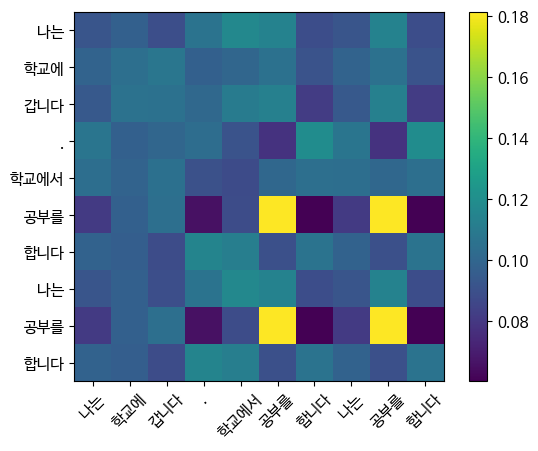

In [ ]:
weights = attention_weights[0,0].detach().numpy()
plt.imshow(weights)
plt.xticks(range(len(sentence)),sentence,rotation=45)
plt.yticks(range(len(sentence)),sentence)
plt.colorbar()
plt.show()

In [ ]:
for i, q_word in enumerate(sentence):
  attended = [(sentence[j],round(weights[i][j],2) )  for j in range(len(sentence))]
  attended.sort(key=lambda x:x[1],reverse=True)
  print(f'{q_word} 에 대한 어텐션 : {attended}')


나는 에 대한 어텐션 : [('학교에서', 0.12), ('.', 0.11), ('공부를', 0.11), ('공부를', 0.11), ('학교에', 0.1), ('나는', 0.09), ('갑니다', 0.09), ('합니다', 0.09), ('나는', 0.09), ('합니다', 0.09)]
학교에 에 대한 어텐션 : [('갑니다', 0.11), ('공부를', 0.11), ('공부를', 0.11), ('나는', 0.1), ('학교에', 0.1), ('.', 0.1), ('학교에서', 0.1), ('나는', 0.1), ('합니다', 0.09), ('합니다', 0.09)]
갑니다 에 대한 어텐션 : [('학교에', 0.11), ('갑니다', 0.11), ('학교에서', 0.11), ('공부를', 0.11), ('공부를', 0.11), ('.', 0.1), ('나는', 0.09), ('나는', 0.09), ('합니다', 0.08), ('합니다', 0.08)]
. 에 대한 어텐션 : [('합니다', 0.12), ('합니다', 0.12), ('나는', 0.11), ('나는', 0.11), ('학교에', 0.1), ('갑니다', 0.1), ('.', 0.1), ('학교에서', 0.09), ('공부를', 0.08), ('공부를', 0.08)]
학교에서 에 대한 어텐션 : [('나는', 0.1), ('학교에', 0.1), ('갑니다', 0.1), ('공부를', 0.1), ('합니다', 0.1), ('나는', 0.1), ('공부를', 0.1), ('합니다', 0.1), ('.', 0.09), ('학교에서', 0.09)]
공부를 에 대한 어텐션 : [('공부를', 0.18), ('공부를', 0.18), ('학교에', 0.1), ('갑니다', 0.1), ('학교에서', 0.09), ('나는', 0.08), ('나는', 0.08), ('.', 0.07), ('합니다', 0.06), ('합니다', 0.06)]
합니다 에 대한 어텐션 : [('.', 0.11), ('학교에서', 0.11),

In [ ]:
# 셀프어텐션 구조를 이용해서
# 문장내의 단어들간의 중요도를 히트맵으로 시각화 하고
# 특정 단어를 입력했을때 그 단어와 가장중한 단어 top 5 출력

# 작업순서
# 한글문장(기사나 기타등등..) -> 전처리 -> 토큰화 -> 단어임베딩(단어:고유값) -> 셀프어텐션 적용

In [ ]:
new_text = '''
샌프란시스코 자이언츠 이정후(27)가 메이저리그 통산 105승에 빛나는 콜롬비아 출신 베테랑 좌완 호세 퀸타나(36·밀워키 브루어스)에게 꽁꽁 묶였다. 퀸타나는 다른 타자들에게 던지지 않은 슬러브로 이정후의 타이밍을 무너뜨렸다.

이정후는 23일(이하 한국시간) 미국 캘리포니아주 샌프란시스코 오라클파크에서 치러진 2025 메이저리그 밀워키와의 홈경기에 3번 타자 중견수로 선발 출장, 4타수 무안타 1볼넷을 기록했다.


2경기 연속 출루에 성공했으나 안타를 치지 못한 이정후는 시즌 타율이 3할2푼9리에서 3할1푼5리(89타수 28안타)로 떨어졌다. OPS는 .983에서 .947로 내려왔다.

밀워키 선발로 나온 콜롬비아 출신 베테랑 좌완 퀸타나에게 당한 경기였다. 1회말 2사 주자 없는 첫 타석에서 퀸타나를 상대한 이정후는 유격수 내야 뜬공으로 물러났다. 볼카운트 1-2에서 5구째 바깥쪽 낮은 시속 77.3마일(124.4km) 슬러브에 타이밍을 빼앗기며 팝플라이가 나왔다.

3회말 2사 1,3루 찬스에선 헛스윙 삼진을 당했다. 초구 몸쪽 높은 싱커에 몸을 피하면서 헛스윙이 나온 이정후는 2구째 바깥쪽 존에 들어온 싱커를 지켜보며 투스트라이크를 먹었다. 3구째 볼을 골라내고, 4구째 몸쪽 싱커를 파울로 커트했지만 5구째 퀸타나의 바깥쪽 낮게 원바운드로 떨어진 시속 78.5마일(126.3km) 슬러브에 배트가 헛돌았다. 이정후답지 않게 배트와 공 차이가 큰 헛스윙. 주자 2명이 잔루로 남았다.

[사진] 밀워키 호세 퀸타나. ⓒGettyimages(무단전재 및 재배포 금지)

[사진] 밀워키 호세 퀸타나. ⓒGettyimages(무단전재 및 재배포 금지)
스코어가 1-11로 크게 벌어진 6회말 세 번째 타석에서도 이정후는 퀸타나 공략에 실패했다. 초구 스트라이크를 지켜본 뒤 2구째 볼을 골라낸 이정후는 3구째 바깥쪽 낮은 시속 78.5마일(126.3km) 슬러브를 잡아당겼지만 1루 땅볼로 선행 주자가 2루에서 포스 아웃됐다.

8회말에도 이정후는 좌완 투수를 상대했다. 밀워키 좌완 불펜 브라이언 허드슨을 상대로 8구 승부 끝에 볼넷으로 출루하며 1루를 밟았다. 1~3구 연속 볼을 본 이정후는 4~5구 연속 스트라이크를 지켜봤다. 풀카운트에서 6~7구 연속 파울 커트 이후 8구째 바깥쪽 낮은 볼을 골라내며 1루로 걸어나갔다. 이어 크리스티안 코스의 몸에 맞는 볼로 2루에 진루한 이정후는 윌머 플로레스의 우전 적시타 때 홈을 밟아 득점을 올렸다.

9회말 2사 1,2루 마지막 타석에선 우익수 뜬공으로 물러나며 이날 경기 마지막 아웃카운트를 기록했다. 밀워키 우완 조엘 파이암프스의 초구 몸쪽 높은 시속 94.7마일(152.4km) 포심 패스트볼을 받아쳤지만 높게 떴다.

[사진] 샌프란시스코 조던 힉스. ⓒGettyimages(무단전재 및 재배포 금지)

[사진] 샌프란시스코 조던 힉스. ⓒGettyimages(무단전재 및 재배포 금지)
이날 경기는 샌프란시스코가 3-11 대패를 당했다. 선발투수 조던 힉스가 5이닝 8피안타 3볼넷 5탈삼진 6실점(5자책)으로 무너지며 시즌 3패(1승)째 안았다. 두 번째 투수 루 트리비노가 ⅔이닝 3피안타(2피홈런) 1볼넷 5실점 난타를 당하면서 6회초 8실점 빅이닝을 허용했다.

밀워키 선발 퀸타나가 6이닝 6피안타 2볼넷 3탈삼진 1실점 호투로 승리투수가 됐다. 최고 시속 92.2마일(148.4km), 평균 90.5마일(145.6km) 싱커(36개)를 비롯해 체인지업(29개), 커브, 포심 패스트볼(이상 12개), 슬러브(5개)를 구사했다. 슬러브를 5개만 던졌는데 전부 이정후 상대로만 쓰며 타이밍 뺴앗는데 주력했다. 시즌 3승째이자 개인 통산 105승째를 거둔 퀸타나는 시즌 평균자책점 0점대(0.71→0.96)를 유지했다.

밀워키 타선에선 크리스티안 옐리치가 시즌 5호 홈런 포함 5타수 2안타 4타점으로 맹타를 휘둘렀다. 밀워키는 13승11패, 샌프란시스코는 15승9패가 됐다
'''

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 36.1 MB/s eta 0:00:00


In [ ]:
# 전처리
from konlpy.tag import Okt
import re
# 한글만 추출
new_text = re.sub(r'[^ㄱ-ㅎ가-힣\s]','',new_text)
new_text = re.sub(r'\n|\r\n','',new_text)
okt = Okt()
sentence = [word for word in okt.nouns(new_text) if len(word) >=2]
vocab = {word:i for i , word in enumerate(set(sentence))}
encoded = [vocab[token] for token in sentence]
print(len(encoded))
# 임베딩 차원을 8로 설정한 레이어
embeding_size = 8
embedding = nn.Embedding(len(vocab), embeding_size)
# 토큰을 임베딩으로 변환
token_embeddings = embedding(torch.tensor(encoded))
# 배치차원 추가
token_embeddings = token_embeddings.unsqueeze(0)
print(token_embeddings.shape)
# token_embeddings,sentence
attention = SelfAttention(embed_size=8,heads=2)
# 셀프어텐션에서는 query ,key ,value가 모두 동일한 입력
output,attention_weights = attention(token_embeddings,token_embeddings,token_embeddings)
print(f'입력형태 : {token_embeddings.shape}')
print(f'출력형태 : {output.shape}')
print(f'어텐션 가중치 : {attention_weights.shape}')  # [1, 2, vocab_size, vocab_size  각 헤드별 query-key간의 유사

290
torch.Size([1, 290, 8])
입력형태 : torch.Size([1, 290, 8])
출력형태 : torch.Size([1, 290, 8])
어텐션 가중치 : torch.Size([1, 2, 290, 290])


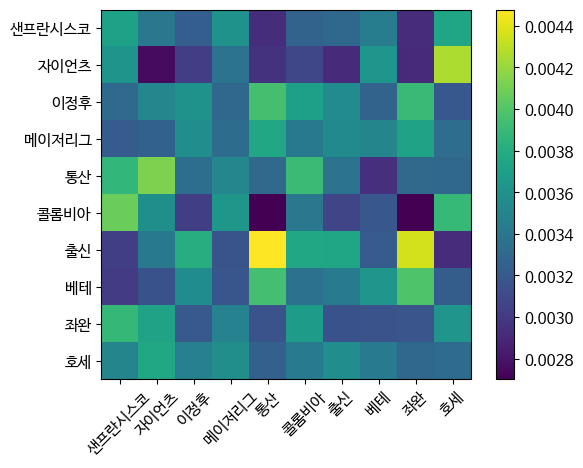

In [ ]:
# 문장내의 단어들간의 중요도를 히트맵으로 시각화 하고
weights = attention_weights[0,0].detach().numpy()
w = weights[:10,:10]
plt.imshow(w)
plt.xticks(range(len(sentence[:10])),sentence[:10],rotation=45)
plt.yticks(range(len(sentence[:10])),sentence[:10])
plt.colorbar()
plt.show()

In [ ]:
# 특정 단어를 입력했을때 그 단어와 가장중한 단어 top 5 출력
q_word = '중견수'
assert(q_word in sentence),"찾고자 하는 단어가 없습니다."
i = np.where(np.array(sentence) == q_word)[0][0]
attended = [(sentence[j],weights[i][j] )  for j in range(len(sentence))]
attended.sort(key=lambda x:x[1],reverse=True)
print(f'{q_word} 에 대한 top 10 \n : {attended[:10]}')

중견수 에 대한 top 10 
 : [('초구', 0.004216942), ('초구', 0.004216942), ('초구', 0.004216942), ('이상', 0.004210847), ('패승', 0.0041930834), ('바운드', 0.0040902006), ('시속', 0.004080972), ('시속', 0.004080972), ('시속', 0.004080972), ('시속', 0.004080972)]


In [ ]:
q_word in sentence

True